<a href="https://colab.research.google.com/github/TheLiss/mlcourse_notebooks/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [3]:
dataset = pd.read_csv(DATA_PATH + 'hour_online.csv')

In [4]:
dataset.head()

,Time,Users
0,1/1/17 0:00,34002
1,1/1/17 1:00,37947
2,1/1/17 2:00,41517
3,1/1/17 3:00,44476
4,1/1/17 4:00,46234


<ipython-input-5-6cd90aad3cda>:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<Axes: xlabel='Time', ylabel='Users'>

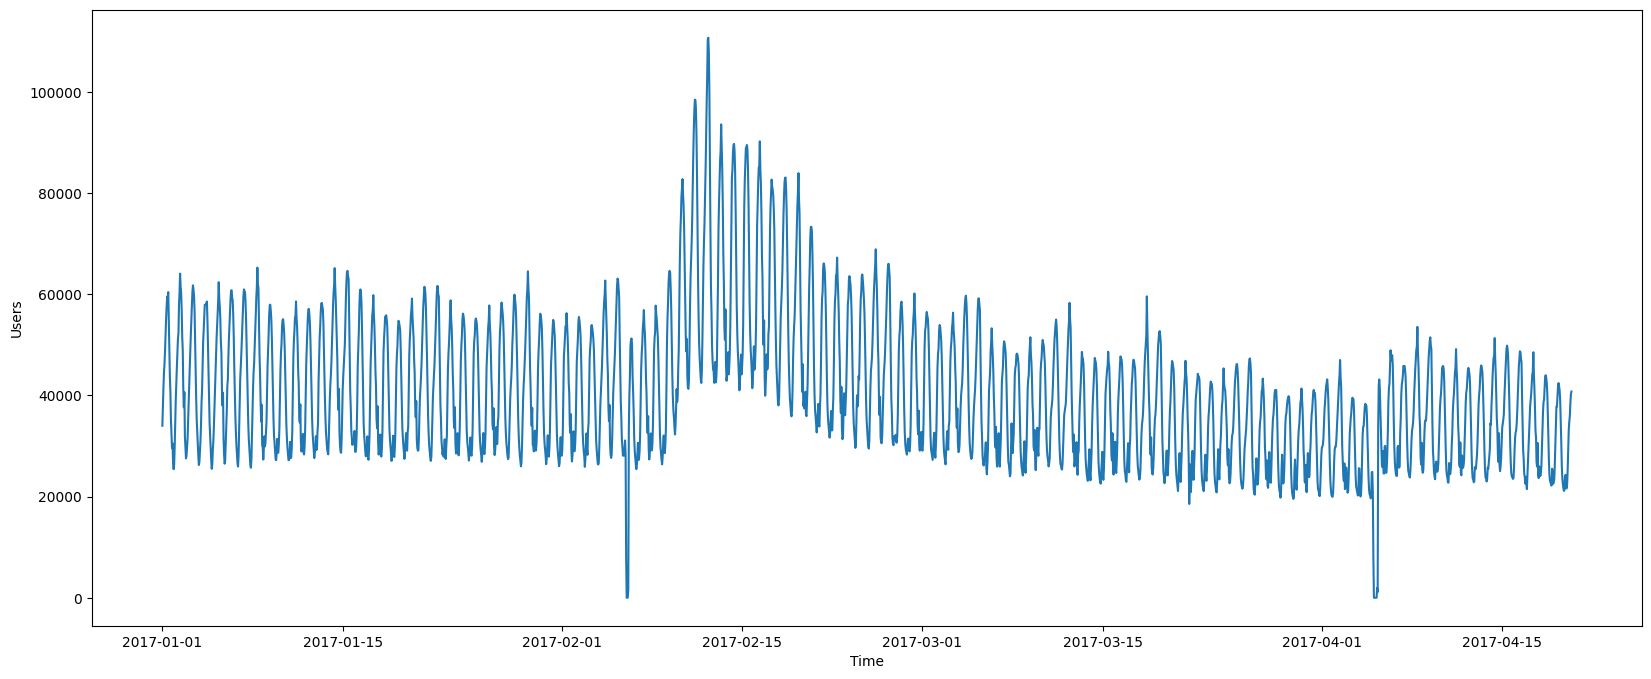

In [5]:
dataset = pd.read_csv(DATA_PATH + '/hour_online.csv', index_col='Time', parse_dates=['Time'])
plt.figure(figsize=(20,8))
sns.lineplot(data=dataset, x='Time', y='Users')

In [6]:
def moving_avg(series, n):
  return np.average(series[-n:])

In [7]:
def plotMovingAvg(series, n):
  rolling_mean = series.rolling(window=n).mean()

  plt.figure(figsize=(20, 8))
  plt.title(f'Moving average\n Window size = {n}')
  plt.plot(rolling_mean, 'g')

  plt.plot(dataset)
  plt.legend()
  plt.grid()

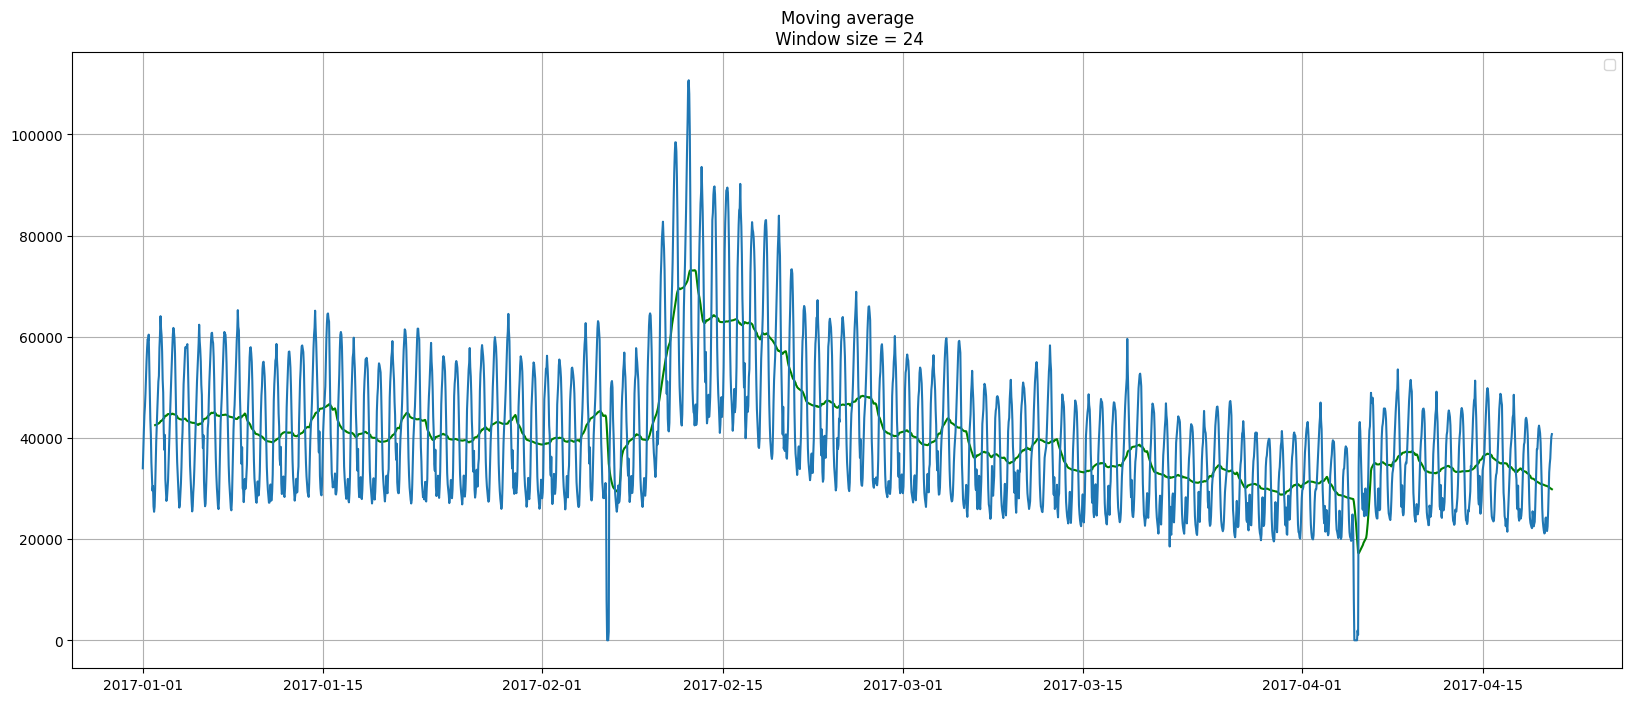

In [8]:
plotMovingAvg(dataset, 24)

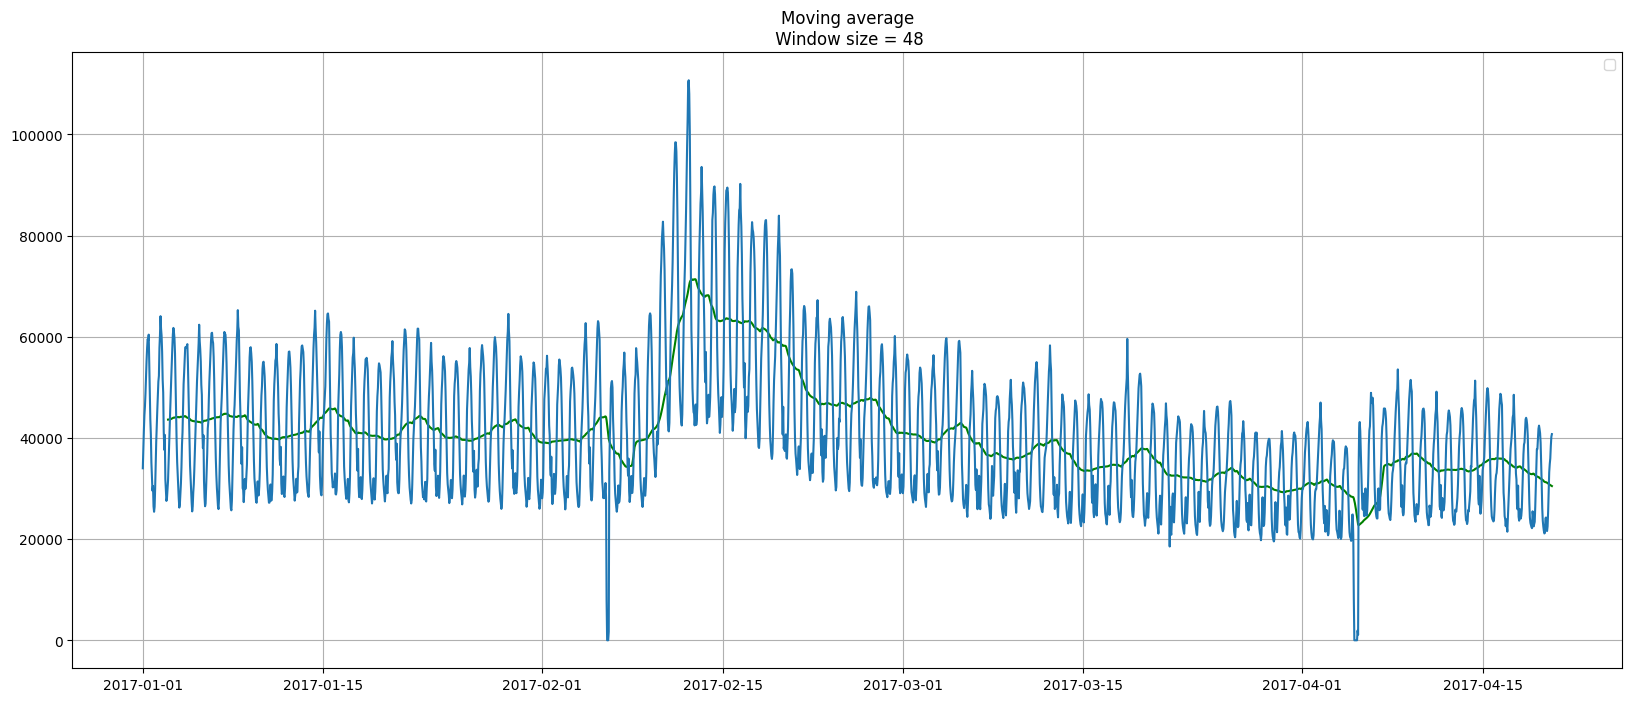

In [9]:
plotMovingAvg(dataset, 24*2)

In [10]:
def exponential_smoothing(series, alpha):
  result = [series[0]]
  for n in range(1, len(series)):
    result.append(series[n] * alpha + (1- alpha) * result[n - 1])
  return result

<ipython-input-10-a60b2a496e88>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-10-a60b2a496e88>:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



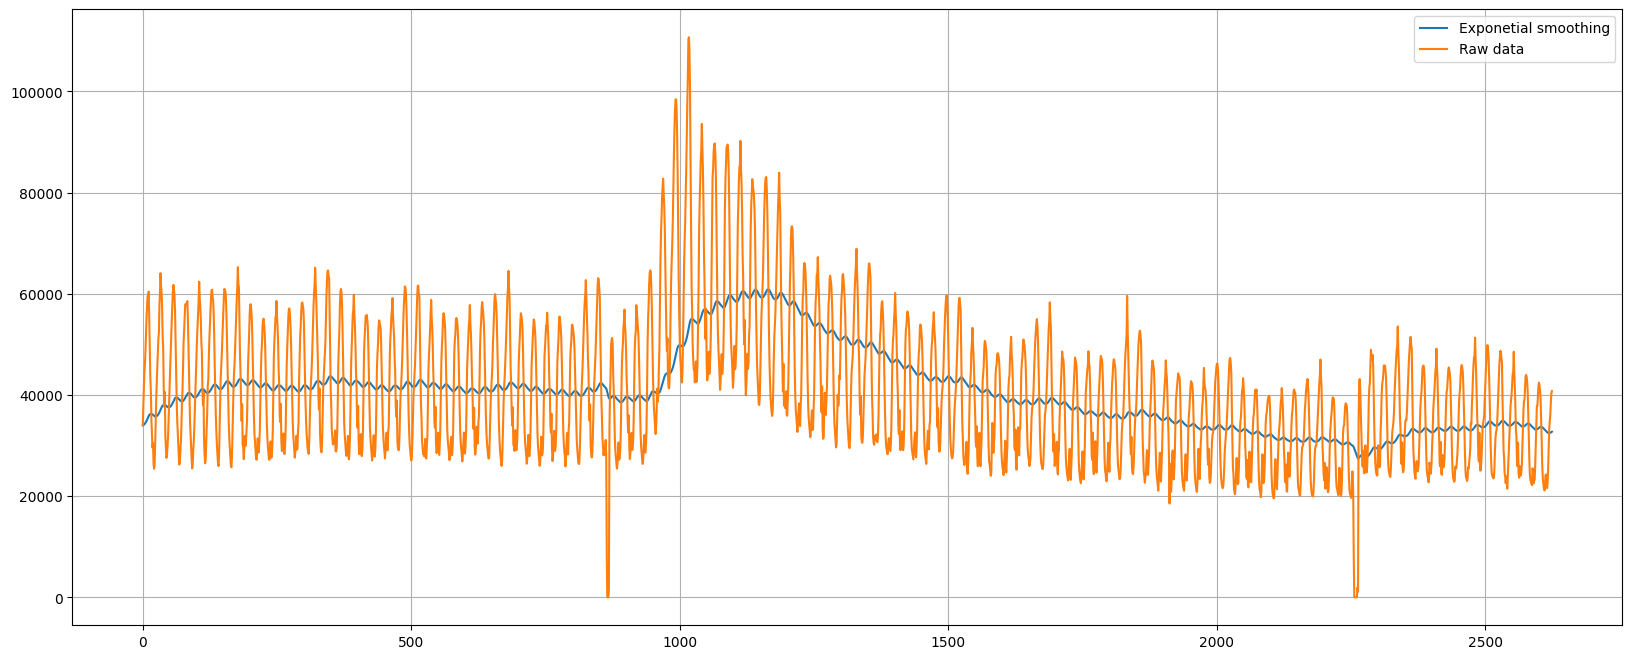

In [11]:
exponential = exponential_smoothing(dataset['Users'], 0.01)
plt.figure(figsize=(20, 8))
plt.plot(exponential, label='Exponetial smoothing')
plt.plot(dataset['Users'].values, label='Raw data')
plt.grid()
plt.legend()

In [12]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

<ipython-input-12-c5abc3b21e22>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-c5abc3b21e22>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-c5abc3b21e22>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



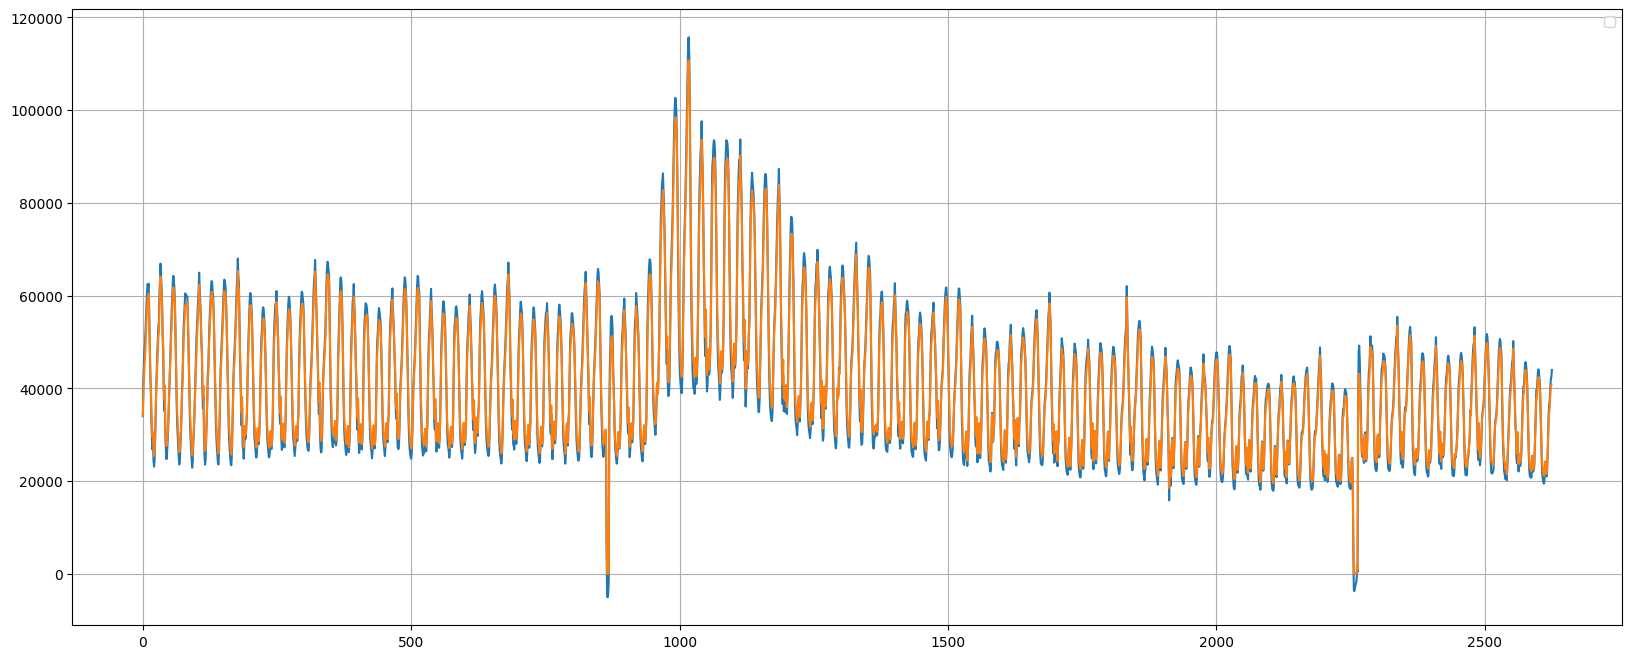

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(double_exponential_smoothing(dataset['Users'], 0.9, 0.2))
plt.plot(dataset['Users'].values)
plt.grid()
plt.legend()

In [14]:
from sklearn.model_selection import TimeSeriesSplit

In [15]:
data = pd.DataFrame(dataset)

In [16]:
data.head()

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


In [17]:
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['weekend'] = data['weekday'].isin([5,6])

In [18]:
data.head()

,Users,hour,weekday,weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,True
2017-01-01 01:00:00,37947,1,6,True
2017-01-01 02:00:00,41517,2,6,True
2017-01-01 03:00:00,44476,3,6,True
2017-01-01 04:00:00,46234,4,6,True


In [19]:
data.groupby('weekday').mean()

,Users,hour,weekend
weekday,,,
0,38730.143229,11.500000,0.0
1,38632.828125,11.500000,0.0
2,38128.518229,11.500000,0.0
3,39519.035135,11.310811,0.0
4,41505.152778,11.500000,0.0
5,43717.708333,11.500000,1.0
6,43392.143603,11.524804,1.0


In [20]:
def preprocessing(data, lag_start, lag_end, test_size=0.3):
  data = pd.DataFrame(data.copy())
  test_index = int(len(data) *  (1-test_size))

  for i in range(lag_start, lag_end):
    data[f'lag_{i}'] = data['Users'].shift(i)

  data['hour'] = data.index.hour
  data['weekday'] = data.index.weekday
  data['weekend'] = data['weekday'].isin([5,6])

  data['weekday_average'] = data['weekday'].apply(lambda x: data[data['weekday'] == x]['Users'].mean())
  data['hour_average'] = data['hour'].apply(lambda x: data[data['hour'] == x]['Users'].mean())

  data.drop(['hour', 'weekday'], axis=1, inplace=True)
  data = data.dropna()
  data = data.reset_index(drop=True)

  X_train = data.loc[:test_index].drop(['Users'], axis=1)
  X_test = data.loc[test_index:].drop(['Users'], axis=1)
  y_train = data.loc[:test_index]['Users']
  y_test = data.loc[test_index:]['Users']

  return X_train, X_test, y_train, y_test


In [21]:
preprocessing(data, 5, 20)[0].head(10)

,weekend,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,weekday_average,hour_average
0,True,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,41517.0,37947.0,34002.0,43392.143603,27349.045872
1,True,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,41517.0,37947.0,43392.143603,27474.137615
2,True,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,41517.0,43392.143603,29336.100917
3,True,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,43392.143603,31567.899083
4,True,29570.0,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,43392.143603,31198.165138
5,False,30493.0,29570.0,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,48842.0,38730.143229,31559.781818
6,False,26472.0,30493.0,29570.0,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,52245.0,38730.143229,33213.163636
7,False,25408.0,26472.0,30493.0,29570.0,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,55245.0,38730.143229,35790.550459
8,False,26367.0,25408.0,26472.0,30493.0,29570.0,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,57725.0,38730.143229,40264.745455
9,False,30011.0,26367.0,25408.0,26472.0,30493.0,29570.0,32073.0,35170.0,40730.0,43710.0,48954.0,54476.0,60425.0,59285.0,59534.0,38730.143229,45419.118182


In [22]:
X_train, X_test, y_train, y_test = preprocessing(data, lag_start = 12, lag_end=48)

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
lr = LinearRegression()

In [25]:
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
prediction = lr.predict(X_test)

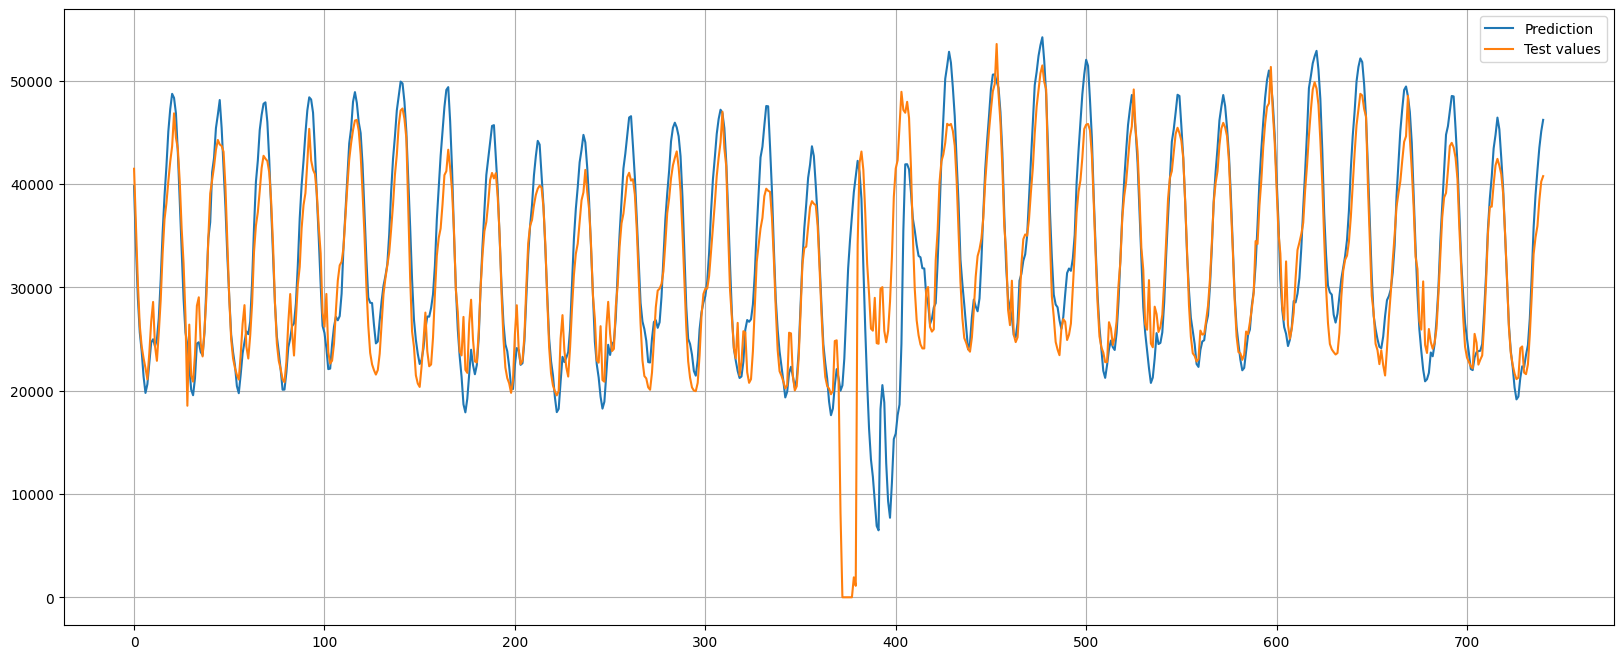

In [27]:
plt.figure(figsize=(20,8))
plt.plot(prediction, label='Prediction')
plt.plot(y_test.values, label='Test values')
plt.grid()
plt.legend()

In [28]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

In [29]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1838, 39)
Size of each fold: 367

Splitting the first 2 chunks at 1/2
Size of train + test: (734, 39)

Splitting the first 3 chunks at 2/3
Size of train + test: (1101, 39)

Splitting the first 4 chunks at 3/4
Size of train + test: (1468, 39)

Splitting the first 5 chunks at 4/5
Size of train + test: (1835, 39)


4727.577903717616

In [30]:
import xgboost as xgb

In [48]:
def xgb_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):
  X_train, X_test, y_train, y_test = preprocessing(data, lag_start=lag_start, lag_end=lag_end, test_size=test_size)
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test)
  param_grid = {
      'objective': 'reg:squarederror',
      'booster': 'gblinear'
  }
  trees = 1000

  cv = xgb.cv(param_grid, dtrain, metrics = 'rmse', nfold=10, num_boost_round=trees)

  boost = xgb.train(param_grid, dtrain, num_boost_round = cv['test-rmse-mean'].argmin())

  deviation = cv.loc[cv['test-rmse-mean'].argmin()]['test-rmse-mean']

  prediction_train = boost.predict(dtrain)
  plt.figure(figsize=(15, 5))
  plt.plot(prediction_train)
  plt.plot(y_train)
  plt.axis('tight')
  plt.grid(True)

    # и на тестовом
  prediction_test = boost.predict(dtest)
  lower = prediction_test-scale*deviation
  upper = prediction_test+scale*deviation

  Anomalies = np.array([np.NaN]*len(y_test))
  Anomalies[y_test<lower] = y_test[y_test<lower]

  plt.figure(figsize=(15, 5))
  plt.plot(prediction_test, label="prediction")
  plt.plot(lower, "r--", label="upper bond / lower bond")
  plt.plot(upper, "r--")
  plt.plot(list(y_test), label="y_test")
  plt.plot(Anomalies, "ro", markersize=10)
  plt.legend(loc="best")
  plt.axis('tight')
  plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
  plt.grid(True)
  plt.legend()

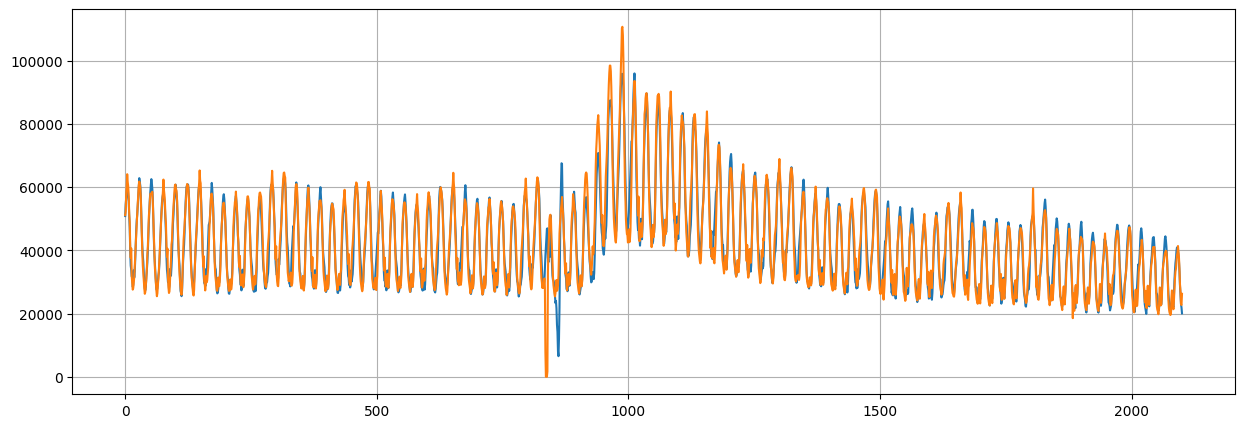

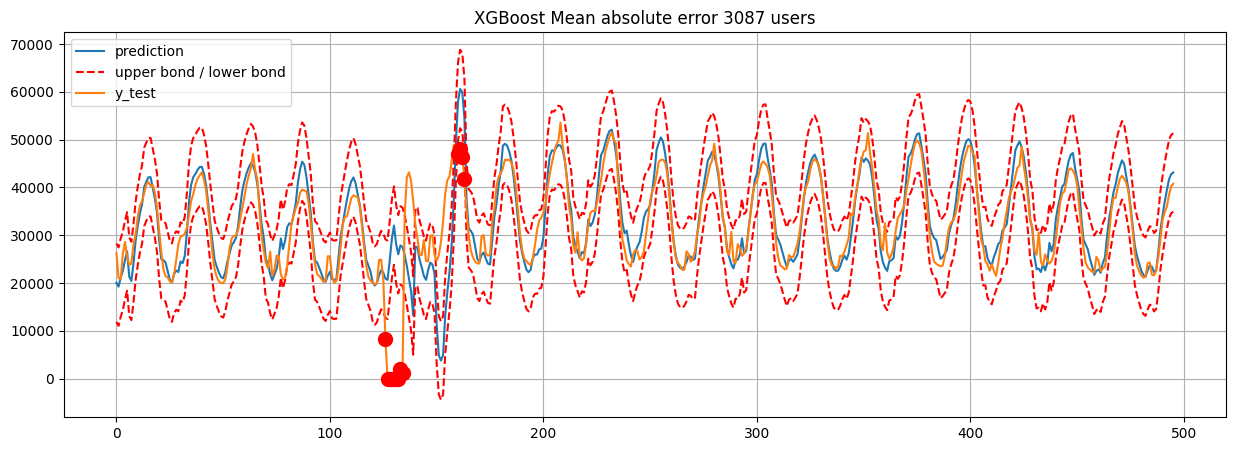

In [49]:
xgb_forecast(dataset, test_size=0.2, lag_start=5, lag_end=30)